### 1. Import Library

In [1]:
# import libraries used

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  OneHotEncoder, LabelEncoder

import swifter
import gc

### 2. Load Dataset

In [2]:
# load categories
df_cats = pd.read_csv("item_categories.csv")
# load items
df_items = pd.read_csv("items.csv")
# load transaction data for trainning
df_train = pd.read_csv("sales_train.csv")
# load test data set
df_test = pd.read_csv("test.csv")
# load shops
df_shops = pd.read_csv("shops.csv")

In [3]:
len(df_train)

2935849

### 3. Data Cleaning

#### 3.1 Checking Missing Data

In [4]:
# check if there is any data missing
df_cats.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [5]:
# check if there is any data missing
df_items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [6]:
# check if there is any data missing
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [7]:
# check if there is any data missing
df_shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

#### 3.2 Removing Outliers

In [8]:
# check if there are any other abnormal values.
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


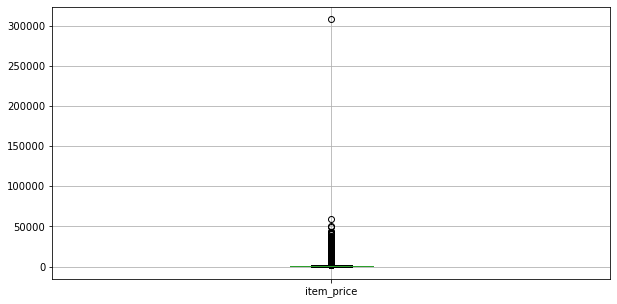

In [9]:
# boxplot item_price and item_cnt_day
plt.figure(figsize=(10,5)) 
df_train.boxplot(column=['item_price'])
plt.show()
plt.close()

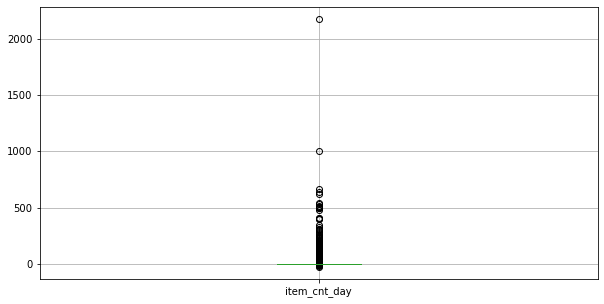

In [10]:
plt.figure(figsize=(10,5)) 
df_train.boxplot(column=['item_cnt_day'])
plt.show()
plt.close()

In [11]:
# check which item has the abnormal price
df_train[df_train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [12]:
# check the price of the item of the same shop within the same month.
df_train[(df_train.shop_id == 32) & (df_train.item_id == 2973) & (df_train.date_block_num == 4)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484683,15.05.2013,4,32,2973,-1.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


In [13]:
# formatting date column dtype from object to datetime
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y')

In [14]:
# check the price of the item of different shops on the same day.
df_train[(df_train.item_id == 2973) & (df_train.date_block_num == 4) & (df_train.date == "2013-05-15")]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


In [15]:
# It can be determined that the price shall be 1249.0 or 1249.5 on 2013-05-15

df_train.loc[484683, "item_price"] = 1249.0
df_train[(df_train.item_id == 2973) & (df_train.date_block_num == 4) & (df_train.date == "2013-05-15")]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,1249.0,1.0


In [16]:
# drop outliers and correct wrong values for item_price.
df_train = df_train[(df_train['item_price'] > 0) & (df_train['item_price'] < 49000)]

<AxesSubplot:>

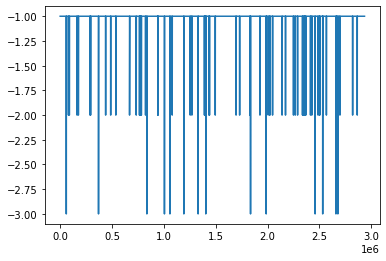

In [17]:
# drop outliers of item_cnt_day
df_train = df_train[(df_train.item_cnt_day > -4) & (df_train.item_cnt_day <= 20)]
df_train[df_train.item_cnt_day < 0].item_cnt_day.plot()

In [18]:
df_train[(df_train.date_block_num == 1)&(df_train.item_id == 149)&(df_train.shop_id==45)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
197670,2013-02-12,1,45,149,249.0,1.0


#### 3.3 Category Data Cleaning

In [19]:
# df_shops cleaning
df_shops.loc[df_shops.shop_name == 'Воронеж (Плехановская, 13)',"shop_name" ] = 'Воронеж ТРЦ (Плехановская, 13)'
df_shops.loc[df_shops.shop_name == 'Жуковский ул. Чкалова 39м?',"shop_name" ] = 'Жуковскийул. ТЦ Чкалова 39м²'
df_shops.loc[df_shops.shop_name == 'Москва МТРЦ "Афи Молл"',"shop_name" ] = 'Москва ТРЦ "Афи Молл"'
df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
df_shops.loc[df_shops.shop_name == 'Якутск Орджоникидзе, 56',"shop_name" ] = 'Якутск ТЦ Орджоникидзе, 56'
df_shops.loc[df_shops.shop_name == 'Москва ТРК "Атриум"',"shop_name" ] = 'Москва ТРЦ "Атриум"'
df_shops.loc[df_shops.shop_name == 'Москва Магазин С21',"shop_name" ] = 'Москва ТЦ Магазин С21'
df_shops.loc[df_shops.shop_name == 'Цифровой склад 1С-Онлайн',"shop_name" ] = 'Цифровой-склад Digital 1С-Онлайн'
df_shops.loc[df_shops.shop_name == 'Интернет-магазин ЧС',"shop_name" ] = 'Интернет-магазин Онлайн ЧС'

# split shop name to city and type.
df_shops["shop_city"] = df_shops.shop_name.str.split(" ").map( lambda x: x[0] )
df_shops["shop_type"] = df_shops.shop_name.str.split(" ").map( lambda x: x[1] )
df_shops

,shop_name,shop_id,shop_city,shop_type
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,ТРЦ
6,"Воронеж ТРЦ (Плехановская, 13)",6,Воронеж,ТРЦ
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,ТРЦ
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,ТРЦ
9,Выездная Торговля,9,Выездная,Торговля


In [20]:
# correct shop_id 

df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57
df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58
df_train.loc[df_train.shop_id == 11, 'shop_id'] = 10

df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 11, 'shop_id'] = 10

In [21]:
# df_cats cleaning

df_cats.loc[df_cats.item_category_id == 0, 'item_category_name'] = 'Аксессуары - PC(Гарнитуры/Наушники)'
df_cats.loc[df_cats.item_category_id == 8, 'item_category_name'] = 'Служебные - Билеты(Цифра)'
df_cats.loc[df_cats.item_category_id == 9, 'item_category_name'] = 'Служебные - Доставка товара'
#df_cats.loc[df_cats.item_category_id == 25, 'item_category_name'] = 'Аксессуары - для игр'
#df_cats.loc[df_cats.item_category_id == 32, 'item_category_name'] = 'Карты оплаты - (Кино, Музыка, Игры)'
#df_cats.loc[df_cats.item_category_id == 34, 'item_category_name'] = 'Карты оплаты - Цифра'
#df_cats.loc[df_cats.item_category_id == 36, 'item_category_name'] = 'Карты оплаты - Цифра'
df_cats.loc[df_cats.item_category_id == 37, 'item_category_name'] = 'Кино - Blu_Ray'
df_cats.loc[df_cats.item_category_id == 38, 'item_category_name'] = 'Кино - Blu_Ray 3D'
df_cats.loc[df_cats.item_category_id == 39, 'item_category_name'] = 'Кино - Blu_Ray 4K'
#df_cats.loc[df_cats.item_category_id == 44, 'item_category_name'] = 'Книги - Аудиокниги'
#df_cats.loc[df_cats.item_category_id == 45, 'item_category_name'] = 'Книги - Аудиокниги'
#df_cats.loc[df_cats.item_category_id == 55, 'item_category_name'] = 'Музыка - CD'
#df_cats.loc[df_cats.item_category_id == 56, 'item_category_name'] = 'Музыка - CD'
#df_cats.loc[df_cats.item_category_id == 65, 'item_category_name'] = 'Подарки - Настольные игры'
#df_cats.loc[df_cats.item_category_id == 70, 'item_category_name'] = 'Подарки - Сувениры'
#df_cats.loc[df_cats.item_category_id == 76, 'item_category_name'] = 'Программы - Для дома и офиса'
#df_cats.loc[df_cats.item_category_id == 78, 'item_category_name'] = 'Программы - Обучающие'
#df_cats.loc[df_cats.item_category_id == 80, 'item_category_name'] = 'Билеты - Служебные'
df_cats.loc[df_cats.item_category_id == 81, 'item_category_name'] = 'Чистые носители - шпиль'
df_cats.loc[df_cats.item_category_id == 82, 'item_category_name'] = 'Чистые носители - штучные'


df_cats["cat_type"] = df_cats.item_category_name.apply(lambda x: x.split("-")[0].strip()).astype(str)
df_cats.loc[ (df_cats.cat_type == "Игровые консоли"), "cat_type" ] = "консоли"

df_cats["split"] = df_cats.item_category_name.apply(lambda x: x.split("-"))
df_cats["sub_type"] = df_cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [22]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

df_items["item_name"] = df_items["item_name"].apply(lambda x: name_correction(x))

In [23]:
# correct wrong categoried data of digital items. Shop 55 is the only shop selling digital products.

df_train.loc[((df_train.shop_id == 55) & (df_train.item_id == 9244)), 'item_id'] = 9246
df_train.loc[((df_train.shop_id == 55) & (df_train.item_id == 9248)), 'item_id'] = 9250
df_train.loc[((df_train.shop_id == 55) & (df_train.item_id == 9252)), 'item_id'] = 9254
df_train.loc[((df_train.shop_id != 55) & (df_train.item_id == 9246)), 'item_id'] = 9244
df_train.loc[((df_train.shop_id != 55) & (df_train.item_id == 9250)), 'item_id'] = 9248
df_train.loc[((df_train.shop_id != 55) & (df_train.item_id == 9254)), 'item_id'] = 9252

In [24]:
df_train[(df_train.date_block_num == 1)&(df_train.item_id == 149)&(df_train.shop_id==45)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
197670,2013-02-12,1,45,149,249.0,1.0


### 4. Data Preprocessing

#### 4.1 Data Analysis/Sum/Binning

In [25]:
# check test data set.

test_item_ids = set(df_test.item_id)
train_item_ids = set(df_train.item_id)
missing_34 = (test_item_ids - train_item_ids.intersection(test_item_ids))

count = 0
for index, row in df_test.iterrows():
    if row['item_id'] in missing_34:
        count += 1
print("{} missing items of test set in the training data set(including validation)".format(len(missing_34)))
print("The percentage of missing items is {:.2f}%.".format(count/len(df_test)*100))

363 missing items of test set in the training data set(including validation)
The percentage of missing items is 7.12%.


In [26]:
# check test data set.

test_item_ids = set(df_test.item_id)
train_item_ids = set(df_train[df_train.date_block_num < 33].item_id)
missing_33_34 = (test_item_ids - train_item_ids.intersection(test_item_ids))

count = 0
for index, row in df_test.iterrows():
    if row['item_id'] in missing_33_34:
        count += 1
print("{} missing item of validation set in the training data set(not including validation)".format(len(missing_33_34)))
print("The percentage of missing items is {:.2f}%.".format(count/len(df_test)*100))

646 missing item of validation set in the training data set(not including validation)
The percentage of missing items is 12.67%.


In [27]:
# merge df_train with df_items, but drop item_name columns

# record original columns
cols = list(df_train.columns)
# merge df_train with df_items
df_train = pd.merge(df_train, df_items[["item_id", "item_category_id"]], on=["item_id"])
# reorder the columns
cols.insert(cols.index('item_id') + 1, 'item_category_id')
# rearrange columns of df_train
df_train = df_train.loc[:, cols]

In [28]:
# generate monthly shop_item sales and merge with the train data set.

item_sales = df_train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({'item_cnt_day':['sum']})
item_sales.columns = ['date_block_num', 'shop_id', 'item_id'] + ['date_shop_item_cnt']

df_train = pd.merge(df_train, item_sales, on=['date_block_num', 'shop_id', 'item_id'], how = 'left')
df_train['date_shop_item_cnt'] = (df_train['date_shop_item_cnt'].fillna(0).clip(0,20).astype(np.float32))

del item_sales

df_train

,date,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day,date_shop_item_cnt
0,2013-01-02,0,59,22154,37,999.0,1.0,1.0
1,2013-01-23,0,24,22154,37,999.0,1.0,1.0
2,2013-01-20,0,27,22154,37,999.0,1.0,1.0
3,2013-01-02,0,25,22154,37,999.0,1.0,5.0
4,2013-01-03,0,25,22154,37,999.0,1.0,5.0
...,...,...,...,...,...,...,...,...
2932414,2015-10-17,33,25,8428,40,249.0,1.0,1.0
2932415,2015-10-01,33,25,7903,15,12198.0,1.0,1.0
2932416,2015-10-29,33,25,7610,64,2890.0,1.0,1.0
2932417,2015-10-22,33,25,7635,64,2100.0,1.0,1.0


In [29]:
df_train['item_revenue'] = df_train['item_price'] * df_train['item_cnt_day'] / 1000
df_train['item_revenue'] = df_train['item_revenue'].astype(np.float16)


In [30]:

revenue = df_train.groupby(['date_block_num', 'shop_id'], as_index=False).agg({'item_revenue':['sum']})
revenue.columns = ['date_block_num', 'shop_id'] + ['date_shop_revenue']

df_train = pd.merge(df_train, revenue, on=['date_block_num', 'shop_id'], how = 'left')
df_train['date_shop_revenue'] = (df_train['date_shop_revenue'].fillna(0))

del revenue

df_train

,date,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day,date_shop_item_cnt,item_revenue,date_shop_revenue
0,2013-01-02,0,59,22154,37,999.0,1.0,1.0,0.999023,1634.0
1,2013-01-23,0,24,22154,37,999.0,1.0,1.0,0.999023,1432.0
2,2013-01-20,0,27,22154,37,999.0,1.0,1.0,0.999023,4728.0
3,2013-01-02,0,25,22154,37,999.0,1.0,5.0,0.999023,5376.0
4,2013-01-03,0,25,22154,37,999.0,1.0,5.0,0.999023,5376.0
...,...,...,...,...,...,...,...,...,...,...
2932414,2015-10-17,33,25,8428,40,249.0,1.0,1.0,0.249023,7052.0
2932415,2015-10-01,33,25,7903,15,12198.0,1.0,1.0,12.195312,7052.0
2932416,2015-10-29,33,25,7610,64,2890.0,1.0,1.0,2.890625,7052.0
2932417,2015-10-22,33,25,7635,64,2100.0,1.0,1.0,2.099609,7052.0


In [31]:
revenue = df_train.groupby(['date_block_num', 'shop_id', 'item_category_id'], as_index=False).agg({'item_revenue':['sum']})
revenue.columns = ['date_block_num', 'shop_id', 'item_category_id'] + ['date_shop_cat_revenue']

df_train = pd.merge(df_train, revenue, on=['date_block_num', 'shop_id','item_category_id'], how = 'left')
df_train['date_shop_cat_revenue'] = (df_train['date_shop_cat_revenue'].fillna(0))

del revenue

df_train

,date,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day,date_shop_item_cnt,item_revenue,date_shop_revenue,date_shop_cat_revenue
0,2013-01-02,0,59,22154,37,999.0,1.0,1.0,0.999023,1634.0,27.12500
1,2013-01-23,0,24,22154,37,999.0,1.0,1.0,0.999023,1432.0,38.21875
2,2013-01-20,0,27,22154,37,999.0,1.0,1.0,0.999023,4728.0,167.62500
3,2013-01-02,0,25,22154,37,999.0,1.0,5.0,0.999023,5376.0,282.50000
4,2013-01-03,0,25,22154,37,999.0,1.0,5.0,0.999023,5376.0,282.50000
...,...,...,...,...,...,...,...,...,...,...,...
2932414,2015-10-17,33,25,8428,40,249.0,1.0,1.0,0.249023,7052.0,232.00000
2932415,2015-10-01,33,25,7903,15,12198.0,1.0,1.0,12.195312,7052.0,16.25000
2932416,2015-10-29,33,25,7610,64,2890.0,1.0,1.0,2.890625,7052.0,155.75000
2932417,2015-10-22,33,25,7635,64,2100.0,1.0,1.0,2.099609,7052.0,155.75000


In [32]:
del df_train['date']
del df_train['item_cnt_day']
del df_train['item_revenue']

In [33]:
df_train.corr()

,date_block_num,shop_id,item_id,item_category_id,item_price,date_shop_item_cnt,date_shop_revenue,date_shop_cat_revenue
date_block_num,1.000000,-0.008489,0.009293,0.029255,0.095688,-0.019449,0.041103,-0.112129
shop_id,-0.008489,1.000000,0.030908,0.018037,-0.027856,0.011356,0.028143,0.066292
item_id,0.009293,0.030908,1.000000,0.368379,-0.134438,-0.055301,0.044271,-0.116826
item_category_id,0.029255,0.018037,0.368379,1.000000,-0.254760,-0.061008,0.042705,-0.304375
item_price,0.095688,-0.027856,-0.134438,-0.254760,1.000000,0.081524,0.014446,0.109759
date_shop_item_cnt,-0.019449,0.011356,-0.055301,-0.061008,0.081524,1.000000,0.183514,0.267964
date_shop_revenue,0.041103,0.028143,0.044271,0.042705,0.014446,0.183514,1.000000,0.451786
date_shop_cat_revenue,-0.112129,0.066292,-0.116826,-0.304375,0.109759,0.267964,0.451786,1.000000


In [34]:
df_price = df_train[['item_price']].drop_duplicates()
df_price

,item_price
0,999.00
18,657.00
36,299.00
59,899.00
61,949.00
...,...
2932179,3898.90
2932180,3998.98
2932349,29999.00
2932415,12198.00


In [35]:
df_price.item_price, bins = pd.qcut(df_price.item_price, q=20,labels=False, retbins=True)
df_price

,item_price
0,11
18,8
36,3
59,10
61,10
...,...
2932179,18
2932180,18
2932349,19
2932415,19


In [36]:
'''
array([7.00000e-02, 6.80000e+01, 9.80000e+01, 1.40000e+02, 1.51880e+02,
       1.98000e+02, 2.30000e+02, 2.59000e+02, 2.99000e+02, 3.49000e+02,
       3.99000e+02, 4.79480e+02, 5.72000e+02, 6.98000e+02, 8.16610e+02,
       9.99000e+02, 1.19978e+03, 1.50000e+03, 1.99870e+03, 2.86180e+03,
       4.29900e+04])
'''

'\narray([7.00000e-02, 6.80000e+01, 9.80000e+01, 1.40000e+02, 1.51880e+02,\n       1.98000e+02, 2.30000e+02, 2.59000e+02, 2.99000e+02, 3.49000e+02,\n       3.99000e+02, 4.79480e+02, 5.72000e+02, 6.98000e+02, 8.16610e+02,\n       9.99000e+02, 1.19978e+03, 1.50000e+03, 1.99870e+03, 2.86180e+03,\n       4.29900e+04])\n'

In [37]:
def apply_item_price_qcut(row):
    for i in range(0, 21):
        if row.item_price <= bins[i]:
            return i

df_train['item_price_qcut'] = df_train.swifter.apply(apply_item_price_qcut, axis=1).astype(np.int8)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [38]:
del df_train['item_price']

df_train.rename(columns={'item_price_qcut':'item_price'}, inplace=True)

In [39]:
#df_train.sort_values(['date_block_num','shop_id','item_id'], inplace = True)
#df_train

<AxesSubplot:>

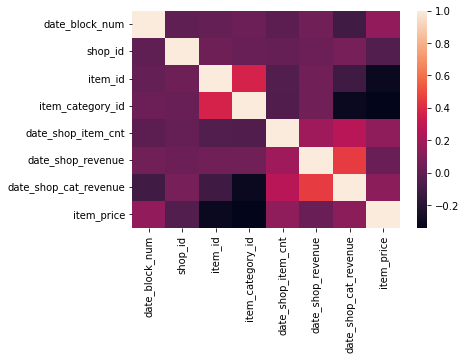

In [40]:
sns.heatmap(df_train.corr())

In [41]:
df_train.corr()

,date_block_num,shop_id,item_id,item_category_id,date_shop_item_cnt,date_shop_revenue,date_shop_cat_revenue,item_price
date_block_num,1.000000,-0.008489,0.009293,0.029255,-0.019449,0.041103,-0.112129,0.146047
shop_id,-0.008489,1.000000,0.030908,0.018037,0.011356,0.028143,0.066292,-0.055711
item_id,0.009293,0.030908,1.000000,0.368379,-0.055301,0.044271,-0.116826,-0.309590
item_category_id,0.029255,0.018037,0.368379,1.000000,-0.061008,0.042705,-0.304375,-0.341488
date_shop_item_cnt,-0.019449,0.011356,-0.055301,-0.061008,1.000000,0.183514,0.267964,0.143004
date_shop_revenue,0.041103,0.028143,0.044271,0.042705,0.183514,1.000000,0.451786,0.022863
date_shop_cat_revenue,-0.112129,0.066292,-0.116826,-0.304375,0.267964,0.451786,1.000000,0.131648
item_price,0.146047,-0.055711,-0.309590,-0.341488,0.143004,0.022863,0.131648,1.000000


#### 4.2 Save DataSet

In [42]:
# save clean categories
df_cats.to_csv("v30_item_categories_clean.csv", index=False)
# save clean items
df_items.to_csv("v30_items_clean.csv", index=False)
# save transaction data for trainning
df_train.to_csv("v30_sales_train_clean.csv", index=False)
# save test data set
df_test.to_csv("v30_test_clean.csv", index=False)
# load shops
df_shops.to_csv("v30_shops_clean.csv", index=False)

In [43]:
print("complete!")

complete!


In [44]:
del df_train

In [45]:
gc.collect()

73